# import libraries

In [1]:
import os
import re
import docx
import csv
import pandas as pd
import numpy as np
import pathlib

#for similarity analysis
## use pip install sentence-transformers
from sentence_transformers import SentenceTransformer, util
import matplotlib.pyplot as plt
## use pip install scikit-learn 
from sklearn.metrics.pairwise import cosine_similarity

# Collection of the data : 
* choice to perform it from an online survey at
    * first iteration at https://forms.gle/7d1jEtoqDeSqiXPS9
    * deprecated for https://forms.gle/oF4uMZNu3c2Mg97G7 (a survey for each situation unit)


In [2]:
os.getcwd()

'/Users/louisdelamarre/Desktop/my-R-projects/DatathonRobotonomie'

In [3]:

entries = os.listdir()
list_csv = []
for entry in entries :
    if re.search(".*csv$", entry):
        list_csv.append(entry)

list_csv


['2022-03-27_robotonomie_data-collection_Forms.csv',
 '2022-03-28_robotonomie_file-management_collection-2.csv']

In [4]:
df = pd.read_csv('2022-03-28_robotonomie_file-management_collection-2.csv')

In [5]:
df

,Horodateur,name,situation_name,situation_text,situation_photo
0,28/03/2022 11:17:01,louis,cerdanya,1.\tWhat is this photo?\nThis is a photo of ou...,https://drive.google.com/open?id=1rsGy_LeROCz3...
1,28/03/2022 11:17:38,louis,plantes,1.\tWhat is this photo?\nThis is a photo of th...,https://drive.google.com/open?id=1MwR4VZtcIc9G...
2,28/03/2022 11:18:13,louis,borely,1.\tWhat is this photo?\nThis is a photo of th...,https://drive.google.com/open?id=1XO2EJSktaoKq...
3,28/03/2022 11:18:44,louis,annecy,1.\tWhat is this photo?\nThis is a photo of la...,https://drive.google.com/open?id=1mO6F5e-Happk...
4,28/03/2022 11:19:23,louis,calanques,1.\tWhat is this photo?\nThis is a photo of th...,https://drive.google.com/open?id=1BOF5DIjTk-UY...
5,28/03/2022 11:20:16,peter,bike trip,1.\tWhat is this photo?\nThis is a photo of ou...,https://drive.google.com/open?id=1KOgwzYsUo4gS...
6,28/03/2022 11:20:47,peter,chicago,1.\tWhat is this photo?\nThis is a photo of my...,https://drive.google.com/open?id=16mq5qXERJThn...
7,28/03/2022 11:21:34,peter,koyasan,1.\tWhat is this photo?\nThis is a photo of th...,https://drive.google.com/open?id=1j06-kYa8f8oc...
8,28/03/2022 11:22:45,peter,marathon,1.\tWhat is this photo?\nThis is a photo of th...,https://drive.google.com/open?id=1KGmay1c3G9Xx...
9,28/03/2022 11:23:16,peter,newyork,1.\tWhat is this photo?\nThis is a photo of me...,https://drive.google.com/open?id=1x5TFr-2HZ3mH...


# Create the architecture of the desired dataframe "text_df"

In [6]:
df.columns
df.dtypes


Horodateur         object
name               object
situation_name     object
situation_text     object
situation_photo    object
dtype: object

In [7]:
# drop 'Horodateur'
df = df.drop("Horodateur", axis = 1)

In [8]:
#nb_entries =
df.shape

(10, 4)

In [9]:
## counting the nb of situations - This part is no longer required as the collection of data changed#
#count_nb_situation = []
#for column in df.columns: 
#    if re.search(".*photo$", column):
#        count_nb_situation.append(column)
##count_nb_situation
#
#nb_situations = len(count_nb_situation)

## framing the text dataframe - this is no longer required
#text_df = pd.DataFrame(
#    {
#    "text_id" : np.tile(np.arange(1, len(df.name) * nb_situations+1),1)
 #   }
#)
#text_df = {"text_id" : range(1:)}

#user_names = df['name'].unique()
#user_id_list = []
#for i in user_names:
#    for j in range(5):
#        user_id_list.append(i)

#user_id_list

#text_df['user_id'] = user_id_list

In [10]:
df

,name,situation_name,situation_text,situation_photo
0,louis,cerdanya,1.\tWhat is this photo?\nThis is a photo of ou...,https://drive.google.com/open?id=1rsGy_LeROCz3...
1,louis,plantes,1.\tWhat is this photo?\nThis is a photo of th...,https://drive.google.com/open?id=1MwR4VZtcIc9G...
2,louis,borely,1.\tWhat is this photo?\nThis is a photo of th...,https://drive.google.com/open?id=1XO2EJSktaoKq...
3,louis,annecy,1.\tWhat is this photo?\nThis is a photo of la...,https://drive.google.com/open?id=1mO6F5e-Happk...
4,louis,calanques,1.\tWhat is this photo?\nThis is a photo of th...,https://drive.google.com/open?id=1BOF5DIjTk-UY...
5,peter,bike trip,1.\tWhat is this photo?\nThis is a photo of ou...,https://drive.google.com/open?id=1KOgwzYsUo4gS...
6,peter,chicago,1.\tWhat is this photo?\nThis is a photo of my...,https://drive.google.com/open?id=16mq5qXERJThn...
7,peter,koyasan,1.\tWhat is this photo?\nThis is a photo of th...,https://drive.google.com/open?id=1j06-kYa8f8oc...
8,peter,marathon,1.\tWhat is this photo?\nThis is a photo of th...,https://drive.google.com/open?id=1KGmay1c3G9Xx...
9,peter,newyork,1.\tWhat is this photo?\nThis is a photo of me...,https://drive.google.com/open?id=1x5TFr-2HZ3mH...


# Formatting the text to delete all the questions.

In [11]:
# setting the sentences to delete
exemple = df.situation_text[0]
question1 = "1.\tWhat is this photo?\n"
question2 = "\n2.\tWhere did you take this photo?\n"
question3 = "\n3.\tWhen did you take this photo?\n"
question4 = "\n4.\tWho was with you when you took this photo?\n"
question5 = "\n5.\tWhy do you like this photo?\n"

In [12]:
splitted_sentence = re.split("\n", exemple)
new_sentence = []
discard = []
for sent in splitted_sentence:
    if re.search("^[0-9]", sent) and re.search(".?$", sent):
        discard.append(sent)
    else :
        new_sentence.append(sent)

new_sentence
formatted_new_sentence = ". ".join(new_sentence)
re.sub('\..', '.', formatted_new_sentence)

'This is a photo of our winter vacation bicycle trip. In the backcountry of Cerdanya, in the Pyrenean.This winter.I was with my wife Inès and my friend Pierre.I like to go bicycle touring out of the city to discover new places.'

In [13]:
# creating a function to format the text
def text_formatting(exemple):
    splitted_sentence = re.split("\n", exemple)
    new_sentence = []
    discard = []
    for sent in splitted_sentence:
        if re.search("^[0-9]", sent) and re.search(".?$", sent):
            discard.append(sent)
        else :
            new_sentence.append(sent)

    formatted_new_sentence = ". ".join(new_sentence)
    formatted_new_sentence = re.sub('\..', '.', formatted_new_sentence)
    return formatted_new_sentence

In [14]:
#apply the custom function to the dataframe situation_text column :
df.situation_text = df.situation_text.apply(text_formatting)

In [15]:
df

,name,situation_name,situation_text,situation_photo
0,louis,cerdanya,This is a photo of our winter vacation bicycle...,https://drive.google.com/open?id=1rsGy_LeROCz3...
1,louis,plantes,This is a photo of the plants I grow at home. ...,https://drive.google.com/open?id=1MwR4VZtcIc9G...
2,louis,borely,This is a photo of the fountain in the Borely ...,https://drive.google.com/open?id=1XO2EJSktaoKq...
3,louis,annecy,This is a photo of lake of Annecy during the w...,https://drive.google.com/open?id=1mO6F5e-Happk...
4,louis,calanques,This is a photo of the Parc National des Calan...,https://drive.google.com/open?id=1BOF5DIjTk-UY...
5,peter,bike trip,This is a photo of our summer vacation bicycle...,https://drive.google.com/open?id=1KOgwzYsUo4gS...
6,peter,chicago,This is a photo of my family vacation in chica...,https://drive.google.com/open?id=16mq5qXERJThn...
7,peter,koyasan,This is a photo of the sacred Garan area on Mo...,https://drive.google.com/open?id=1j06-kYa8f8oc...
8,peter,marathon,This is a photo of the Austin marathon. In Aus...,https://drive.google.com/open?id=1KGmay1c3G9Xx...
9,peter,newyork,This is a photo of me and my family on vacatio...,https://drive.google.com/open?id=1x5TFr-2HZ3mH...


In [16]:
df.situation_text[0]

'This is a photo of our winter vacation bicycle trip. In the backcountry of Cerdanya, in the Pyrenean.This winter.I was with my wife Inès and my friend Pierre.I like to go bicycle touring out of the city to discover new places.'

# Similarity Matrix and analysis 

## Model selection and initialization

In [17]:
# List of models optimized for semantic textual similarity can be found at:
# https://docs.google.com/spreadsheets/d/14QplCdTCDwEmTqrn1LH4yrbKvdogK4oQvYO1K1aPR5M/edit#gid=0
#distiluse-base-multilingual-cased-v1
#model = SentenceTransformer('stsb-roberta-large')
#https://www.sbert.net/docs/pretrained_models.html
model = SentenceTransformer('distiluse-base-multilingual-cased-v1')

In [19]:
## what is it ? how is it calculated ? 

#embeddings = np.empty([10,512])
#sim_matrix = np.empty([10,10])

## Calculate text similarity between two sets of sentences

In [46]:
## try to access a list of all sentences for each user
#list_sentences_louis = df.situation_text[df.name == 'louis'].tolist()
#list_sentences_louis

In [47]:
sentences1 = df.situation_text[df.name == 'louis'].tolist()
sentences2 = df.situation_text[df.name == 'peter'].tolist()

# encode list of sentences to get their embeddings
embedding1 = model.encode(sentences1, convert_to_tensor=True)
embedding2 = model.encode(sentences2, convert_to_tensor=True)

# compute similarity scores of two embeddings
cosine_scores = util.pytorch_cos_sim(embedding1, embedding2)

for i in range(len(sentences1)):
    for j in range(len(sentences2)):
        print("Sentence 1:", sentences1[i])
        print("Sentence 2:", sentences2[j])
        print("Similarity Score:", cosine_scores[i][j].item())
        print()

Sentence 1: This is a photo of our winter vacation bicycle trip. In the backcountry of Cerdanya, in the Pyrenean.This winter.I was with my wife Inès and my friend Pierre.I like to go bicycle touring out of the city to discover new places.
Sentence 2: This is a photo of our summer vacation bicycle trip. On a ferry boat on the Seine river.Last summer.I was with my wife Jocelyne, and two daughters, Emilie and Alexia.I have always wanted to go bicycle touring with my family, and this is a picture of that. 
Similarity Score: 0.7166913747787476

Sentence 1: This is a photo of our winter vacation bicycle trip. In the backcountry of Cerdanya, in the Pyrenean.This winter.I was with my wife Inès and my friend Pierre.I like to go bicycle touring out of the city to discover new places.
Sentence 2: This is a photo of my family vacation in chicage. In front of the Bean sculpture in Chicago. In august of 2017.I was with my wife Jocelyne, and two daughters, Emilie and Alexia.It shows our family having

## Create a text similarity matrix

In [49]:
# List of sentences from the collected data from users 'louis' and 'peter'
list_of_paragraphs = df.situation_text.tolist()

In [51]:
embeddings = np.empty([10,512])
sim_matrix = np.empty([10,10])

### Get the embeddings

In [52]:
for i in range(len(list_of_paragraphs)):
    #print(list_of_paragraphs[i])
    sentence_embedding = model.encode(list_of_paragraphs[i], convert_to_tensor=True)
    embeddings[i] = sentence_embedding

### Calculate the similarity 

In [53]:
for i in range(len(list_of_paragraphs)):
    for j in range(len(list_of_paragraphs)):
        sim_matrix[i,j]=cosine_similarity([embeddings[i],embeddings[j]])[0,1]
    

### Plot the similarity

<function matplotlib.pyplot.show(close=None, block=None)>

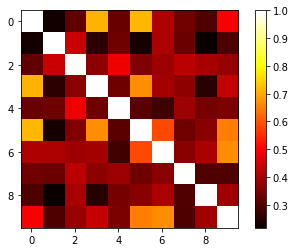

In [54]:
plt.imshow(sim_matrix,cmap="hot")
plt.colorbar()
plt.show

### Next steps :
* find trajectory in matrix to visit different similar photo pairs
* present sequence in a coheret interaction scenario
* use french language